# Detecting DoS attack in SDN using Machine Learning


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

from plotting import plot_learning_curve, plot_validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import scipy
from sklearn.dummy import DummyClassifier

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
#renaming column name because in dataset names are not in a good format. example "classification." is name of label column.

# Loading dataset and Analysis
* separate CSV files for training and testing dataset. 
* renamed column names properly

In [3]:
df1=pd.read_csv("DOS_TrainingT.csv",names=col_names,low_memory=False)
df1=df1.drop(0, axis = 0) #delete column name already present
print('Dimensions of the Training set:',df1.shape)
#loaded training dataset!

Dimensions of the Training set: (40024, 42)


In [4]:
df2=pd.read_csv("DOS_TestingT.csv",names=col_names,low_memory=False)
df2=df2.drop(0, axis = 0) #delete column name already present
print('Dimensions of the Training set:',df2.shape)
#loaded testing dataset!

Dimensions of the Training set: (11211, 42)


In [5]:
#print(df1.info());
df1.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0,0,0,0.05,0,normal
2,0,udp,other,SF,146,0,0,0,0,0,...,1,0,0.6,0.88,0,0,0,0,0,normal
3,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.1,0.05,0,0,1,1,0,0,Dos
4,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1,0,0.03,0.04,0.03,0.01,0,0.01,normal
5,0,tcp,http,SF,199,420,0,0,0,0,...,255,1,0,0,0,0,0,0,0,normal


In [6]:
df1.describe() #training dataset

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
count,40024,40024,40024,40024,40024,40024,40024,40024,40024,40024,...,40024,40024,40024,40024,40024,40024,40024,40024,40024,40024
unique,829,3,64,9,2190,5453,2,3,2,22,...,256,101,101,101,66,101,99,100,101,2
top,0,tcp,http,SF,0,0,0,0,0,0,...,255,1,0,0,0,0,0,0,0,normal
freq,37220,33888,14153,23853,15926,19821,40019,39661,40023,39263,...,12540,15569,14824,21584,28039,25272,25748,34353,35078,23652


In [7]:
#print(df2.info());
df2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0,0,0,0,1,1,Dos
2,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0,0.06,0,0,0,0,1,1,Dos
3,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0,0,0,0,normal
4,0,tcp,http,SF,267,14515,0,0,0,0,...,255,1,0,0.01,0.03,0.01,0,0,0,normal
5,0,tcp,smtp,SF,1022,387,0,0,0,0,...,28,0.11,0.72,0,0,0,0,0.72,0.04,normal


In [8]:
df2.describe() #testing dataset

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
count,11211,11211,11211,11211,11211,11211,11211,11211,11211,11211,...,11211,11211,11211,11211,11211,11211,11211,11211,11211,11211
unique,422,3,63,9,859,2714,2,3,1,13,...,256,101,100,99,42,98,98,101,91,2
top,0,tcp,http,SF,0,0,0,0,0,0,...,255,1,0,0,0,0,0,0,0,normal
freq,10092,9513,5119,7449,3715,4465,11209,11148,11211,10928,...,4795,5730,5476,6465,8021,9022,9224,7205,7880,6318


## Class distribution of dataset

Class distribution of Training set:
normal    23652
Dos       16372
Name: label, dtype: int64


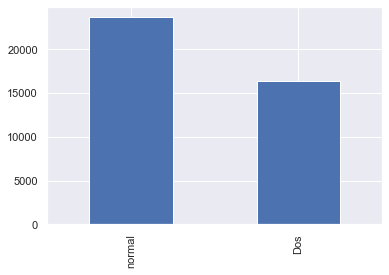

In [9]:
print('Class distribution of Training set:')
df1['label'].value_counts().plot.bar();
print(df1['label'].value_counts());

Class distribution of Training set:
normal    6318
Dos       4893
Name: label, dtype: int64


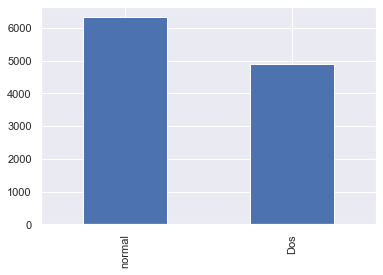

In [10]:
print('Class distribution of Training set:')
df2['label'].value_counts().plot.bar();
print(df2['label'].value_counts())

## Check Null value in dataset

In [11]:
print("number of null value in training dataset")
print(df1.isna().sum().sum())
print("number of null value in testing dataset")
print(df2.isna().sum().sum())

number of null value in training dataset
0
number of null value in testing dataset
0


* No null value in dataset

# Data preprocessing steps

* Here, first we are considering six selected features which are easily extractable from SDN.
* They are count, protocol type, destination byte, source byte, same service rate and duration.
* They are total 3 categorical attributes in dataset and one in selected six features
* In dataset of selected six features, first do one hot encoding on protocol_type feature and scale the dataset
* We need to enode 3 categorical attributes and do scaling to do feature selection based on importance score
* num_outbound_cmds can be deleted from entire dataset as it have only '0' as value in all samples
* Need to convert datatype to float

In [12]:
print(df1['num_outbound_cmds'].value_counts())
print(df2['num_outbound_cmds'].value_counts())

0    40024
Name: num_outbound_cmds, dtype: int64
0    11211
Name: num_outbound_cmds, dtype: int64


* All values of num_outbound_cmds is '0', so dropping it.

In [13]:
df1.drop(['num_outbound_cmds'], axis=1, inplace=True)
df2.drop(['num_outbound_cmds'], axis=1, inplace=True)
# dropping that features because it only have value '0' in entire dataset

In [14]:
df1[["duration","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]] = df1[["duration","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]].astype('float64')
df2[["duration","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]] = df2[["duration","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]].astype('float64')

#changed datatype of numerical to float64

In [15]:
y_train=df1.label
y_test= df2.label
#target

In [16]:
y_train= y_train.map({'Dos': 1, 'normal': 0})
y_test= y_test.map({'Dos': 1, 'normal': 0})
#encoded

In [17]:
X_train=df1.drop(labels=["label"],axis=1)
X_test=df2.drop(labels=["label"],axis=1)

In [18]:
obj_list1=[]
obj_list2=[]
for i in X_train.columns:
    if X_train[i].dtype=='object':
        obj_list1.append(i)
for i in X_test.columns:
    if X_test[i].dtype=='object':
        obj_list2.append(i)
for i in obj_list1:
    x=len(X_train[i].unique())
    print(f"The total unique value of feature {i} is {x} in Training dataset")
for i in obj_list2:
    x=len(X_test[i].unique())
    print(f"The total unique value of feature {i} is {x} in testing dataset")
 #checking unique count of categorical data   

The total unique value of feature protocol_type is 3 in Training dataset
The total unique value of feature service is 64 in Training dataset
The total unique value of feature flag is 9 in Training dataset
The total unique value of feature protocol_type is 3 in testing dataset
The total unique value of feature service is 63 in testing dataset
The total unique value of feature flag is 9 in testing dataset


* Total unique value of service and flag is different in training and testing dataset

In [19]:
tr_service=X_train['service'].tolist()
te_service=X_test['service'].tolist()
te_flag=X_test['flag'].tolist()
tr_flag=X_train['flag'].tolist()
#for adding missing columns to testing and training dataset

In [20]:
add_srv_train=list(set(te_service) - set(tr_service))

In [21]:
add_srv_test=list(set(tr_service) - set(te_service))

In [22]:
add_flag_test=list(set(tr_flag) - set(te_flag))

In [23]:
add_flag_train=list(set(te_flag) - set(tr_flag))

* these are the feature values missing from the testing and training dataset

In [24]:
siX_train=X_train.drop(labels = ['service', 'flag',
       'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'], axis = 1)
#for training dataset with 6 selected features

In [25]:
siX_train.head()

,duration,protocol_type,src_bytes,dst_bytes,count,same_srv_rate
1,0.0,tcp,491.0,0.0,2.0,1.00
2,0.0,udp,146.0,0.0,13.0,0.08
3,0.0,tcp,0.0,0.0,123.0,0.05
4,0.0,tcp,232.0,8153.0,5.0,1.00
5,0.0,tcp,199.0,420.0,30.0,1.00


In [26]:
dums = pd.get_dummies(siX_train['protocol_type'])
siX_train= pd.concat((siX_train,dums), axis = 1)
siX_train.drop(['protocol_type'], axis = 1, inplace=True)

src: labsheet 10 from classroom

In [27]:
siX_train.head()

,duration,src_bytes,dst_bytes,count,same_srv_rate,icmp,tcp,udp
1,0.0,491.0,0.0,2.0,1.00,0,1,0
2,0.0,146.0,0.0,13.0,0.08,0,0,1
3,0.0,0.0,0.0,123.0,0.05,0,1,0
4,0.0,232.0,8153.0,5.0,1.00,0,1,0
5,0.0,199.0,420.0,30.0,1.00,0,1,0


In [28]:
siX_test=X_test.drop(labels = ['service', 'flag',
       'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'], axis = 1)
#for testing dataset with 6 selected features

In [29]:
dums = pd.get_dummies(siX_test['protocol_type'])
siX_test= pd.concat((siX_test,dums), axis = 1)
siX_test.drop(['protocol_type'], axis = 1, inplace=True)

In [30]:
siX_test.head()

,duration,src_bytes,dst_bytes,count,same_srv_rate,icmp,tcp,udp
1,0.0,0.0,0.0,229.0,0.04,0,1,0
2,0.0,0.0,0.0,136.0,0.01,0,1,0
3,2.0,12983.0,0.0,1.0,1.00,0,1,0
4,0.0,267.0,14515.0,4.0,1.00,0,1,0
5,0.0,1022.0,387.0,1.0,1.00,0,1,0


In [31]:
print(siX_test.shape,y_test.shape)
print(siX_train.shape,y_train.shape)

(11211, 8) (11211,)
(40024, 8) (40024,)


### For feature selection, we need to encode all categorical features in training dataset

In [32]:
dums = pd.get_dummies(X_train['service'])
X_train= pd.concat((X_train,dums), axis = 1)
X_train.drop(['service'], axis = 1, inplace=True) 
dums = pd.get_dummies(X_test['service'])
X_test= pd.concat((X_test,dums), axis = 1)
X_test.drop(['service'], axis = 1, inplace=True)#service encoding

In [33]:
dums = pd.get_dummies(X_train['flag'])
X_train= pd.concat((X_train,dums), axis = 1)
X_train.drop(['flag'], axis = 1, inplace=True) 
dums = pd.get_dummies(X_test['flag'])
X_test= pd.concat((X_test,dums), axis = 1)
X_test.drop(['flag'], axis = 1, inplace=True) #flag encoding

In [34]:
dums = pd.get_dummies(X_train['protocol_type'])
X_train= pd.concat((X_train,dums), axis = 1)
X_train.drop(['protocol_type'], axis = 1, inplace=True)
dums = pd.get_dummies(X_test['protocol_type'])
X_test= pd.concat((X_test,dums), axis = 1)
X_test.drop(['protocol_type'], axis = 1, inplace=True)

In [35]:
print(X_train.shape)
print(X_test.shape)

(40024, 113)
(11211, 112)


In [36]:
for i in add_srv_train:
    X_train[i] = 0
for i in add_srv_test:
    X_test[i] = 0
for i in add_flag_train:
    X_train[i] = 0
for i in add_flag_test:
    X_test[i] = 0
#added the missing unique count as column to training and testing

In [37]:
print(X_train.shape)
print(X_test.shape)

(40024, 115)
(11211, 115)


## Feature selection

In [38]:
scalar=StandardScaler()
sc_X_train=scalar.fit_transform(X_train)
sc_X_train=pd.DataFrame(sc_X_train,columns=X_train.columns)
sc_X_test=scalar.fit_transform(X_test)
sc_X_test=pd.DataFrame(sc_X_test,columns=X_test.columns)

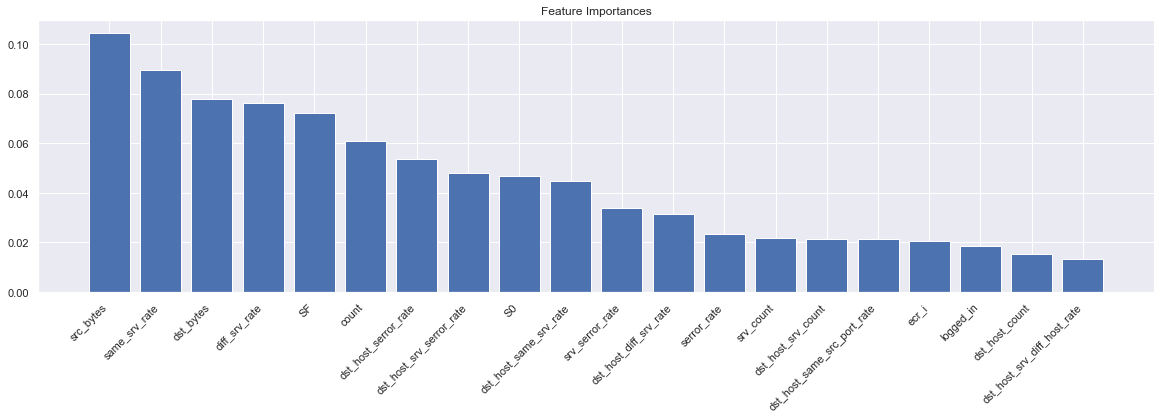

In [39]:
ran=RandomForestClassifier()
ran.fit(sc_X_train,y_train)
importances =np.round(ran.feature_importances_,5)
indices = np.argsort(importances)[::-1]
indices = indices[:20]
names=X_train.columns
f_names = [names[i] for i in indices]
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(0,20), importances[indices])
axes.set_xticks(range(0,20));
axes.set_xticklabels(f_names, rotation=45, ha='right');
#feature selection

* First ten parameters have more impact in calculation so we can consider those parameters here.
src:labsheet 7 from classroom

In [40]:
XX_train=X_train.filter(['same_srv_rate',
 'src_bytes',
 'dst_bytes',
 'SF',
 'diff_srv_rate','count','dst_host_serror_rate','dst_host_srv_serror_rate','SO','dst_host_same_srv_rate'],axis=1)

In [41]:
XX_test=X_test.filter(['same_srv_rate',
 'src_bytes',
 'dst_bytes',
 'SF',
 'diff_srv_rate','count','dst_host_serror_rate','dst_host_srv_serror_rate','SO','dst_host_same_srv_rate'],axis=1)

# Decision tree classifier

In [42]:
d_clf=DecisionTreeClassifier()
d_clf.fit(siX_train,y_train)
pred=d_clf.predict(siX_test)
predT=d_clf.predict(siX_train)

In [43]:
print('==============================  Model Evaluation ==============================')
print()
print(f"Recall of training set: {recall_score(y_train,predT)}")
print(f"Recall of testing set: {recall_score(y_test,pred)}\n" )
print()
print(f"precision score of training set: {precision_score(y_train,predT)}")
print(f"precision score of testing set:{precision_score(y_test,pred)}\n")
print()
print (f"Accuracy score of training set:{accuracy_score(y_train,predT)}")
print (f"Accuracy score of testing set:{accuracy_score(y_test,pred)}\n")
print()
print('==============================  End ==============================')

==============================  Model Evaluation ==============================

Recall of training set: 0.9964573662350354
Recall of testing set: 0.7819333742080523


precision score of training set: 0.9966399902254262
precision score of testing set:0.9615481276702689


Accuracy score of training set:0.9971766939836099
Accuracy score of testing set:0.8911783070198912


==============================  End ==============================


### Running RandomizedSearchCV for selecting best hyperparameters

In [44]:
rand_params = { 'max_depth': scipy.stats.randint(2,50),
                  'min_samples_leaf':scipy.stats.randint(2,50),
                  'min_samples_split':scipy.stats.randint(2,50)}
rand_search = RandomizedSearchCV(d_clf,rand_params,n_iter=10,scoring='recall',n_jobs=-1,cv=StratifiedKFold(n_splits=10))

In [45]:
rand_search.fit(siX_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A7E9ACA0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A7E967F0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A77F8EE0>},
                   scoring='recall')

In [46]:
print(rand_search.best_score_)
print(rand_search.best_params_)

0.9948080223584194
{'max_depth': 39, 'min_samples_leaf': 3, 'min_samples_split': 2}


#### Validating model using learning curve
* src: labsheet 7 from classroom(both learning and validation curve

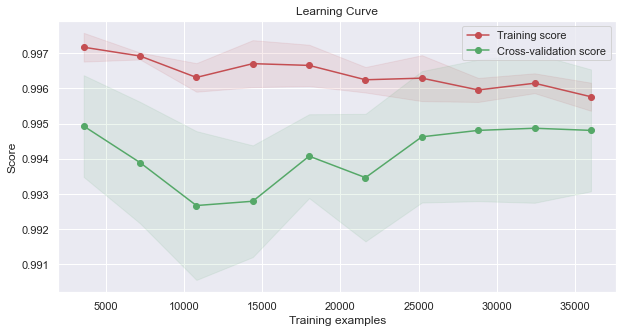

In [47]:
fig=plot_learning_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),train_sizes=np.linspace(.1,1.0,10),scoring='recall')

#### Validation curve of three parameters

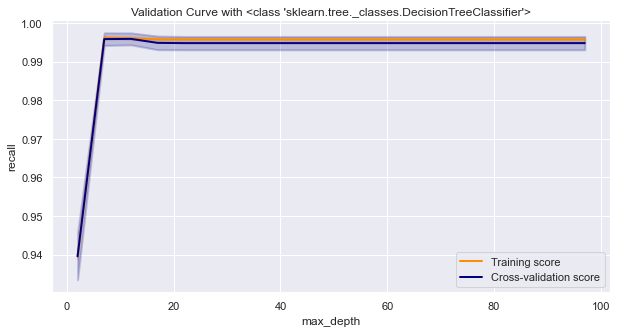

In [48]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(2,100,5),param_name='max_depth',scoring='recall')

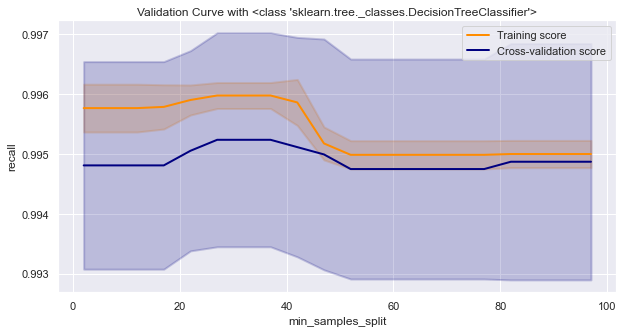

In [49]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(2,100,5),param_name='min_samples_split',scoring='recall')

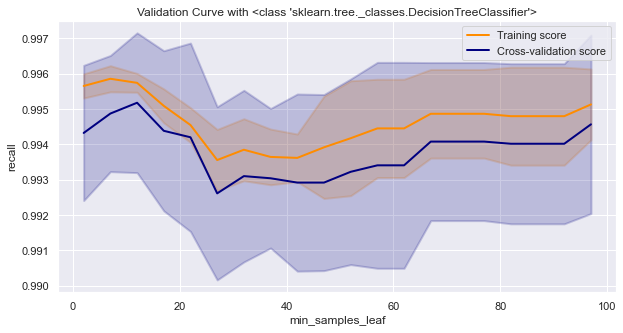

In [50]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(2,100,5),param_name='min_samples_leaf',scoring='recall')

In [51]:
Des_best_est=rand_search.best_estimator_

# Randomforest Classifier 
##### Comparing Randomforest model with dummy

In [52]:
rand=RandomForestClassifier()
rand.fit(siX_train,y_train)
pred=rand.predict(siX_test)
predT=rand.predict(siX_train)

In [53]:
print('==============================  Model Evaluation ==============================')
print()
print(f"Recall of training set: {recall_score(y_train,predT)}")
print(f"Recall of testing set: {recall_score(y_test,pred)}\n" )
print()
print(f"precision score of training set: {precision_score(y_train,predT)}")
print(f"precision score of testing set:{precision_score(y_test,pred)}\n")
print()
print (f"Accuracy score of training set:{accuracy_score(y_train,predT)}")
print (f"Accuracy score of testing set:{accuracy_score(y_test,pred)}\n")
print()
print('==============================  End ==============================')

==============================  Model Evaluation ==============================

Recall of training set: 0.9964573662350354
Recall of testing set: 0.7627222562844881


precision score of training set: 0.9966399902254262
precision score of testing set:0.9663386846193682


Accuracy score of training set:0.9971766939836099
Accuracy score of testing set:0.8848452412808848


==============================  End ==============================


#### Running RandomizedSearchCV for selecting best hyperparameters

In [54]:
rand_search = RandomizedSearchCV(rand,rand_params,n_iter=30,scoring='recall',n_jobs=-1,cv=StratifiedKFold(n_splits=10))

In [55]:
rand_search.fit(siX_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A7E9ACA0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A7E967F0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A77F8EE0>},
                   scoring='recall')

#### Learning curve

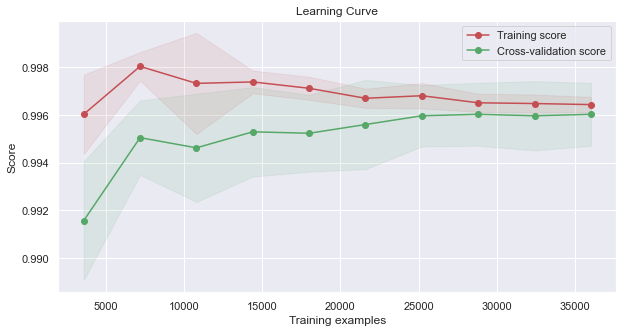

In [56]:
fig=plot_learning_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),train_sizes=np.linspace(.1,1.0,10),scoring='recall')

#### Validation Curve for threee hyperparameters

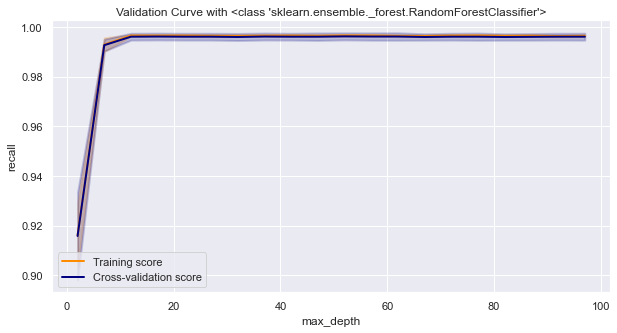

In [57]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(2,100,5),param_name='max_depth',scoring='recall')

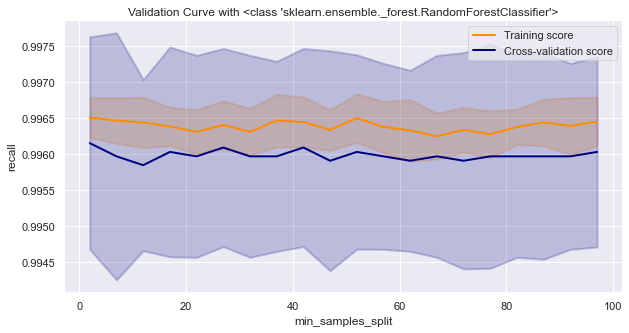

In [58]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(2,100,5),param_name='min_samples_split',scoring='recall')

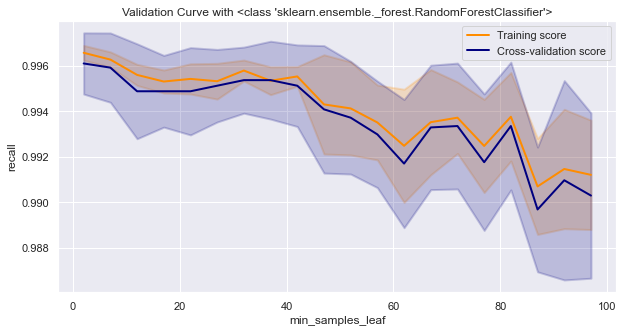

In [59]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(2,100,5),param_name='min_samples_leaf',scoring='recall')

In [60]:
Rand_best_est=rand_search.best_estimator_

# Adaboost Classifier

In [61]:
ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada.fit(siX_train,y_train)
pred=ada.predict(siX_test)
predT=ada.predict(siX_train)

In [62]:
print('==============================  Model Evaluation ==============================')
print()
print(f"Recall of training set: {recall_score(y_train,predT)}")
print(f"Recall of testing set: {recall_score(y_test,pred)}\n" )
print()
print(f"precision score of training set: {precision_score(y_train,predT)}")
print(f"precision score of testing set:{precision_score(y_test,pred)}\n")
print()
print (f"Accuracy score of training set:{accuracy_score(y_train,predT)}")
print (f"Accuracy score of testing set:{accuracy_score(y_test,pred)}\n")
print()
print('==============================  End ==============================')

==============================  Model Evaluation ==============================

Recall of training set: 0.9964573662350354
Recall of testing set: 0.7533210709176374


precision score of training set: 0.9966399902254262
precision score of testing set:0.9636601307189543


Accuracy score of training set:0.9971766939836099
Accuracy score of testing set:0.8799393452858799


==============================  End ==============================


In [63]:
rand_params = { 'n_estimators': scipy.stats.randint(10,500),'learning_rate':np.arange(0.1, 2.1, 0.1)}

In [64]:
rand_search = RandomizedSearchCV(ada,rand_params,n_iter=10,scoring='recall',n_jobs=-1,cv=StratifiedKFold(n_splits=10))

In [65]:
rand_search.fit(siX_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A8CD02E0>},
                   scoring='recall')

In [66]:
f=rand_search.best_estimator_

In [67]:
f.fit(siX_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                   learning_rate=0.7000000000000001, n_estimators=160)

In [68]:
preds=f.predict(siX_test)

In [69]:
recall_score(y_test,preds)

0.7627222562844881

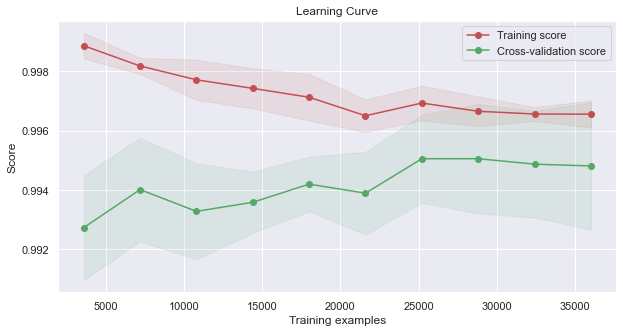

In [70]:
fig=plot_learning_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),train_sizes=np.linspace(.1,1.0,10),scoring='recall')

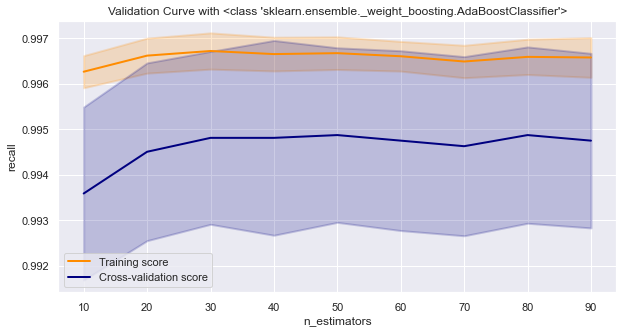

In [71]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(10,100,10),param_name='n_estimators',scoring='recall')

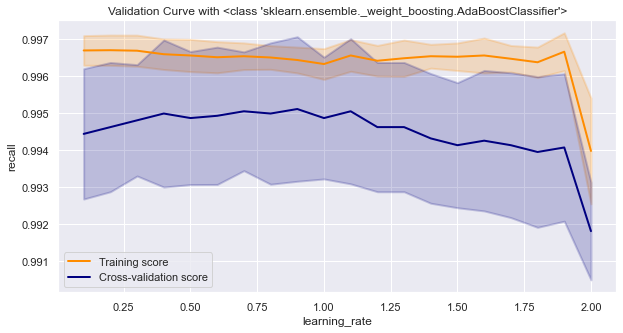

In [72]:
val1=plot_validation_curve(rand_search.best_estimator_,siX_train,y_train,cv=StratifiedKFold(n_splits=10),param_range=np.arange(0.1, 2.1, 0.1),param_name='learning_rate',scoring='recall')

In [73]:
Ada_best_est=rand_search.best_estimator_

# Model with features selected based on importance score

In [74]:
dd_clf=DecisionTreeClassifier()
dd_clf.fit(XX_train,y_train)
pred=dd_clf.predict(XX_test)
predT=dd_clf.predict(XX_train)


In [75]:
print('==============================  Model Evaluation ==============================')
print()
print(f"Recall of training set: {recall_score(y_train,predT)}")
print(f"Recall of testing set: {recall_score(y_test,pred)}\n" )
print()
print(f"precision score of training set: {precision_score(y_train,predT)}")
print(f"precision score of testing set:{precision_score(y_test,pred)}\n")
print()
print (f"Accuracy score of training set:{accuracy_score(y_train,predT)}")
print (f"Accuracy score of testing set:{accuracy_score(y_test,pred)}\n")
print()
print('==============================  End ==============================')

==============================  Model Evaluation ==============================

Recall of training set: 0.9998778402150013
Recall of testing set: 0.7817290006131208


precision score of training set: 1.0
precision score of testing set:0.9683544303797469


Accuracy score of training set:0.9999500299820108
Accuracy score of testing set:0.8935866559628936


==============================  End ==============================


In [76]:
rand_params = { 'max_depth': scipy.stats.randint(2,50),
                  'min_samples_leaf':scipy.stats.randint(2,50),
                  'min_samples_split':scipy.stats.randint(2,50)}
rand_search = RandomizedSearchCV(dd_clf,rand_params,n_iter=10,scoring='recall',n_jobs=-1,cv=StratifiedKFold(n_splits=10))

In [77]:
rand_search.fit(XX_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A9D834F0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A8EB9A00>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000250A9D837C0>},
                   scoring='recall')

In [78]:
fea_best_est=rand_search.best_estimator_

# Comparing with Baseline Model

In [79]:
dum=DummyClassifier(strategy='stratified')

In [80]:
dum.fit(siX_train,y_train)
predum=dum.predict(siX_test)
predT=dum.predict(siX_train)

In [81]:
print('==============================  Model Evaluation ==============================')
print()
print(f"Recall of training set: {recall_score(y_train,predT)}")
print(f"Recall of testing set: {recall_score(y_test,predum)}\n" )
print()
print(f"Precision score of training set: {precision_score(y_train,predT)}")
print(f"Precision score of testing set:{precision_score(y_test,predum)}\n")
print()
print (f"Accuracy score of training set:{accuracy_score(y_train,predT)}")
print (f"Accuracy score of testing set:{accuracy_score(y_test,predum)}\n")
print()
print('==============================  End ==============================')

==============================  Model Evaluation ==============================

Recall of training set: 0.4061202052284388
Recall of testing set: 0.41263028816676883


Precision score of training set: 0.40485903915240823
Precision score of testing set:0.43588082901554404


Accuracy score of training set:0.5128672796322207
Accuracy score of testing set:0.5105699759165105


==============================  End ==============================


### Dummy model of dataset of based on feature selection

In [82]:
dumf=DummyClassifier(strategy='stratified')
dumf.fit(XX_train,y_train)
predum=dum.predict(XX_test)
predT=dum.predict(XX_train)

In [83]:
print('==============================  Model Evaluation ==============================')
print()
print(f"Recall of training set: {recall_score(y_train,predT)}")
print(f"Recall of testing set: {recall_score(y_test,predum)}\n" )
print()
print(f"Precision score of training set: {precision_score(y_train,predT)}")
print(f"Precision score of testing set:{precision_score(y_test,predum)}\n")
print()
print (f"Accuracy score of training set:{accuracy_score(y_train,predT)}")
print (f"Accuracy score of testing set:{accuracy_score(y_test,predum)}\n")
print()
print('==============================  End ==============================')

==============================  Model Evaluation ==============================

Recall of training set: 0.4055094063034449
Recall of testing set: 0.41303903535663195


Precision score of training set: 0.40598055402678407
Precision score of testing set:0.4420384951881015


Accuracy score of training set:0.5141165300819508
Accuracy score of testing set:0.5162786548925162


==============================  End ==============================


# Evaluation with metrics 

### Algorithm based comparison

In [84]:
Des_best_est.fit(siX_train,y_train) # decision tree best estimator
Rand_best_est.fit(siX_train,y_train) # randomforest best estimator
Ada_best_est.fit(siX_train,y_train) #adabooster best estimator
fea_best_est.fit(XX_train,y_train) #decision tree best estimator of features selected based on importance score

DecisionTreeClassifier(max_depth=14, min_samples_leaf=4, min_samples_split=3)

In [85]:
Des_pred=Des_best_est.predict(siX_test)
Rand_pred=Rand_best_est.predict(siX_test)
Ada_pred=Ada_best_est.predict(siX_test)
fea_pred=fea_best_est.predict(XX_test)

In [86]:
print('==============================  Final Evaluation ==============================')
print("Decision tree algorithm")
print(f"Recall of testing set: {recall_score(y_test,Des_pred)}")
print(f"Precision score of testing set: {precision_score(y_test,Des_pred)}" )
print(f"Accuracy of testing set: {accuracy_score(y_test,Des_pred)}\n" )
print("Random forest algorithm")
print(f"Recall of testing set: {recall_score(y_test,Rand_pred)}")
print(f"Precision score of testing set:{precision_score(y_test,Rand_pred)}")
print(f"Accuracy score of testing set:{accuracy_score(y_test,Rand_pred)}\n")
print("AdaBoost algorithm")
print(f"Recall of testing set: {recall_score(y_test,Ada_pred)}")
print(f"Precision score of testing set:{precision_score(y_test,Ada_pred)}")
print(f"Accuracy score of testing set:{accuracy_score(y_test,Ada_pred)}\n")
print("")
print(f"Recall of testing set: {recall_score(y_test,fea_pred)}")
print(f"Precision score of testing set:{precision_score(y_test,fea_pred)}")
print(f"Accuracy score of testing set:{accuracy_score(y_test,fea_pred)}\n")
print()
print('==============================  End ==============================')

==============================  Final Evaluation ==============================
Decision tree algorithm
Recall of testing set: 0.7815246270181893
Precision score of testing set: 0.9615287905456374
Accuracy of testing set: 0.890999910801891

Random forest algorithm
Recall of testing set: 0.7612916411199673
Precision score of testing set:0.963777490297542
Accuracy score of testing set:0.8833288734278834

AdaBoost algorithm
Recall of testing set: 0.7627222562844881
Precision score of testing set:0.9650892164468581
Accuracy score of testing set:0.8843992507358844


Recall of testing set: 0.7894951972205191
Precision score of testing set:0.9693851944792974
Accuracy score of testing set:0.8972437784318973


==============================  End ==============================


Text(0, 0.5, 'Score')

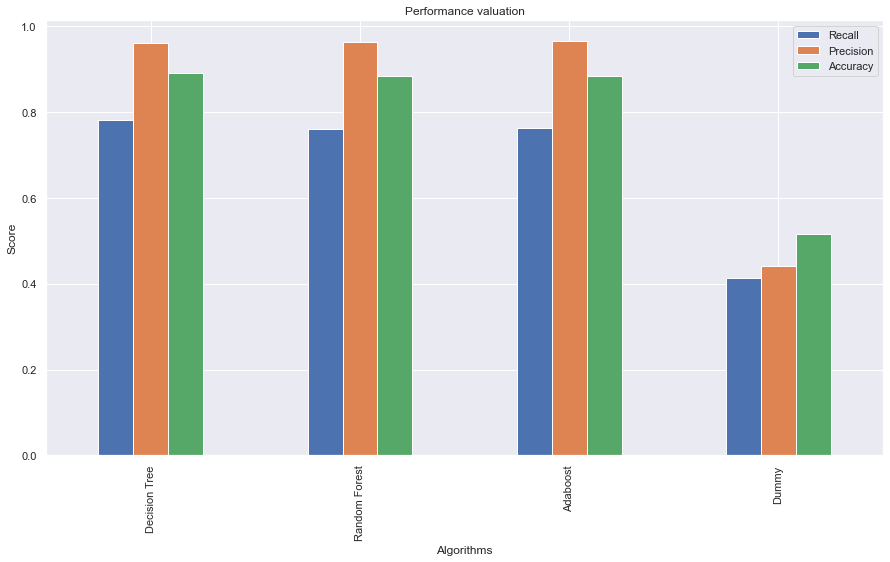

In [87]:
plotdata = pd.DataFrame({

    "Recall":[recall_score(y_test,Des_pred),recall_score(y_test,Rand_pred),recall_score(y_test,Ada_pred),recall_score(y_test,predum)],

    "Precision":[precision_score(y_test,Des_pred),precision_score(y_test,Rand_pred),precision_score(y_test,Ada_pred),precision_score(y_test,predum)],

    "Accuracy":[accuracy_score(y_test,Des_pred),accuracy_score(y_test,Rand_pred),accuracy_score(y_test,Ada_pred),accuracy_score(y_test,predum)]},

    index=["Decision Tree", "Random Forest", "Adaboost", "Dummy"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("Performance valuation")

plt.xlabel("Algorithms")

plt.ylabel("Score")
#src: https://www.analyticsvidhya.com/blog/2021/08/understanding-bar-plots-in-python-beginners-guide-to-data-visualization/

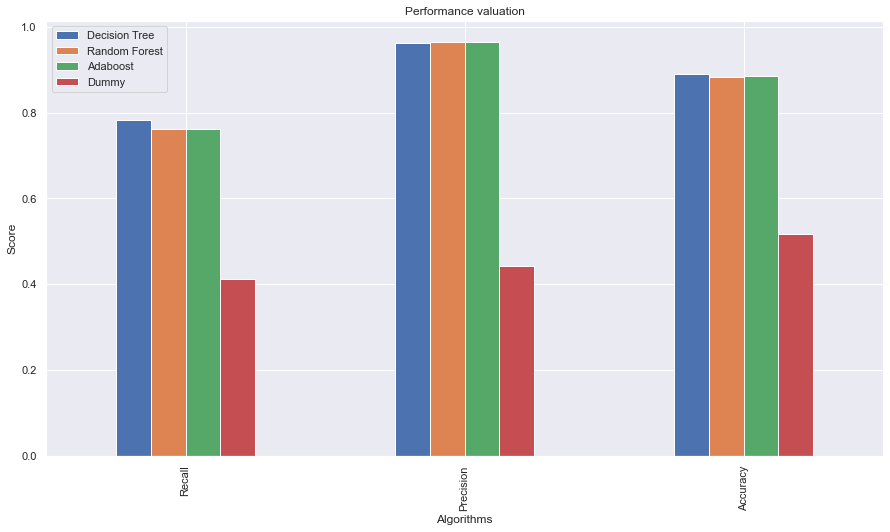

In [88]:
plotdata = pd.DataFrame({

    "Decision Tree":[recall_score(y_test,Des_pred),precision_score(y_test,Des_pred),accuracy_score(y_test,Des_pred)],

    "Random Forest":[recall_score(y_test,Rand_pred),precision_score(y_test,Rand_pred),accuracy_score(y_test,Rand_pred)],

    "Adaboost":[recall_score(y_test,Ada_pred),precision_score(y_test,Ada_pred),accuracy_score(y_test,Ada_pred)],
    "Dummy":[recall_score(y_test,predum),precision_score(y_test,predum),accuracy_score(y_test,predum)]},

    index=["Recall", "Precision", "Accuracy"])

plotdata.plot(kind="bar",figsize=(15, 8));

plt.title("Performance valuation");

plt.xlabel("Algorithms");

plt.ylabel("Score");